# Cheng Hsuan Chiang 
# ID: 12283758
# Homework1: Future Spread Dynamics

## University of Chicago - Financial Mathematics
## FINM 33150 - Regression Analysis and Quantitative Trading Strategies

### Period: December 3, 2019 - August 31, 2021
### 2nd month: number of days to futures expiration is the smalles available value greater than 30 days
### $W = $ CBT_FV_FV $\Rightarrow$ 5-year US T-Notes
### $X = $ CBT_TY_TY $\Rightarrow$ 10-year US T-Notes

$$ W_t = \text{CBT_FV_FV}_t $$

$$ X_t = \text{CBT_TY_TY}_t $$

$$ S_t = X_t - W_t $$

$$ d_t^{(N)} = S_t - MA_{S_t}^{(N)}, N=[5,10,15,20,60] $$


### $Y = $ CBT_TU_TU $\Rightarrow$ 2-year US T-Notes
### $Z = $ CBT_US_US $\Rightarrow$ 30-year US T-Notes

$$ Y_t = \text{CBT_TU_TU}_t $$

$$ Z_t = \text{CBT_US_US}_t $$

$$ S_t = Z_t - Y_t $$

$$ d_t^{(N)} = S_t - MA_{S_t}^{(N)}, N=[5,10,15,20,60] $$



# 1. Data Preperation

**First we retrieve all necessary packages and set global variables:**

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import quandl
import functools
import seaborn as sns
import datetime 
import time
from scipy.stats import kurtosis, kurtosistest, skew, skewtest, norm, jarque_bera
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from calendar import monthrange
from tqdm import tnrange
import warnings
warnings.filterwarnings('ignore')

@functools.lru_cache(maxsize=1000)
def fetch_quandl(my_data_items, trim_start=None, trim_end=None):
    qdata = quandl.get(list(my_data_items), returns="pandas", 
                      trim_start=trim_start, trim_end=trim_end,
                      api_key="CPkrEDEshfeXucLHHk_T")
    return qdata

def clean_quandl_columns(dataframe):
    replacement_columns = {}
    for c in dataframe.columns:
        series_name, variable = c.split(' - ')
        source_name, asset = series_name.split('/')
        replacement_columns[c] = variable
    renamed_data = dataframe.rename(columns=replacement_columns)
    return renamed_data
pd.options.display.max_rows = None

In [2]:
year = ['2019', '2020', '2021']
month = ['H','M','U','Z']

fv = pd.DataFrame()
ty = pd.DataFrame()
tu = pd.DataFrame()
us = pd.DataFrame()

#GET CBT_FV_FV
last_day = pd.Timestamp(datetime.datetime(2019,12,3))
for y in year:
    for m in month:
        fv_name = "OWF/CBT_FV_FV_" + m + y + "_IVM"
        data_seg = quandl.get(fv_name, authtoken="CPkrEDEshfeXucLHHk_T")
        fv = fv.append(data_seg.loc[data_seg.index > last_day])
        last_day = data_seg.index[-1]
fv = fv.loc[pd.Timestamp(datetime.datetime(2019,12,3)):pd.Timestamp(datetime.datetime(2021,8,31))]
fv = fv.iloc[:,[0,15]]
fv = fv.rename(columns={"Future": "Future_FV", "DtT": "DtT_FV"})

#GET CBT_TY_TY
last_day = pd.Timestamp(datetime.datetime(2019,12,3))
for y in year:
    for m in month:
        ty_name = "OWF/CBT_TY_TY_" + m + y + "_IVM"
        data_seg = quandl.get(ty_name, authtoken="CPkrEDEshfeXucLHHk_T")
        ty = ty.append(data_seg.loc[data_seg.index > last_day])
        last_day = data_seg.index[-1]
ty = ty.loc[pd.Timestamp(datetime.datetime(2019,12,3)):pd.Timestamp(datetime.datetime(2021,8,31))]
ty = ty.iloc[:,[0,15]]
ty = ty.rename(columns={"Future": "Future_TY", "DtT": "DtT_TY"})

#GET CBT_TU_TU
last_day = pd.Timestamp(datetime.datetime(2019,12,3))
for y in year:
    for m in month:
        tu_name = "OWF/CBT_TU_TU_" + m + y + "_IVM"
        data_seg = quandl.get(tu_name, authtoken="CPkrEDEshfeXucLHHk_T")
        tu = tu.append(data_seg.loc[data_seg.index > last_day])
        last_day = data_seg.index[-1]
tu = tu.loc[pd.Timestamp(datetime.datetime(2019,12,3)):pd.Timestamp(datetime.datetime(2021,8,31))]
tu = tu.iloc[:,[0,15]]
tu = tu.rename(columns={"Future": "Future_TU", "DtT": "DtT_TU"})

#GET CBT_US_US
last_day = pd.Timestamp(datetime.datetime(2019,12,3))
for y in year:
    for m in month:
        us_name = "OWF/CBT_US_US_" + m + y + "_IVM"
        data_seg = quandl.get(us_name, authtoken="CPkrEDEshfeXucLHHk_T")
        us = us.append(data_seg.loc[data_seg.index > last_day])
        last_day = data_seg.index[-1]
us = us.loc[pd.Timestamp(datetime.datetime(2019,12,3)):pd.Timestamp(datetime.datetime(2021,8,31))]
us = us.iloc[:,[0,15]]
us = us.rename(columns={"Future": "Future_US", "DtT": "DtT_US"})

data = pd.DataFrame(columns = ['Future_TY','DtT_TY','Future_FV','DtT_FV','Spread_TY-FV','Future_US','DtT_US','Future_TU','DtT_TU','Spread_US-TU'])
data['Future_TY']    = ty['Future_TY']
data['DtT_TY']       = ty['DtT_TY']
data['Future_FV']    = fv['Future_FV']
data['DtT_FV']       = fv['DtT_FV']
data['Spread_TY-FV'] = data['Future_TY'] - data['Future_FV'] 
data['Future_US']    = us['Future_US']
data['DtT_US']       = us['DtT_US']
data['Future_TU']    = tu['Future_TU']
data['DtT_TU']       = tu['DtT_TU']
data['Spread_US-TU'] = data['Future_US'] - data['Future_TU'] 
data                 = data.dropna(axis=0, how='any')

In [3]:
# Spread_TY-FV
data_tyfv                  = pd.DataFrame(columns = ['Future_TY','Future_FV','Spread_TY-FV','TY-FV_MA_5','TY-FV_MA_10','TY-FV_MA_15','TY-FV_MA_20','TY-FV_MA_60','TY-FV_Diff_5','TY-FV_Diff_10','TY-FV_Diff_15','TY-FV_Diff_20','TY-FV_Diff_60'])
data_tyfv['Future_TY']     = data['Future_TY']
data_tyfv['Future_FV']     = data['Future_FV']
data_tyfv['Spread_TY-FV']  = data['Spread_TY-FV']

# N-day rolling average of spread, N=5, 10, 15, 20, 60 days
data_tyfv['TY-FV_MA_5']    = data_tyfv['Spread_TY-FV'].rolling(5).mean()
data_tyfv['TY-FV_MA_10']   = data_tyfv['Spread_TY-FV'].rolling(10).mean()
data_tyfv['TY-FV_MA_15']   = data_tyfv['Spread_TY-FV'].rolling(15).mean()
data_tyfv['TY-FV_MA_20']   = data_tyfv['Spread_TY-FV'].rolling(20).mean()
data_tyfv['TY-FV_MA_60']   = data_tyfv['Spread_TY-FV'].rolling(60).mean()

# Difference b/t spread and its N-day rolling average
data_tyfv['TY-FV_Diff_5']  = data_tyfv['Spread_TY-FV'] - data_tyfv['TY-FV_MA_5'] 
data_tyfv['TY-FV_Diff_10'] = data_tyfv['Spread_TY-FV'] - data_tyfv['TY-FV_MA_10'] 
data_tyfv['TY-FV_Diff_15'] = data_tyfv['Spread_TY-FV'] - data_tyfv['TY-FV_MA_15'] 
data_tyfv['TY-FV_Diff_20'] = data_tyfv['Spread_TY-FV'] - data_tyfv['TY-FV_MA_20'] 
data_tyfv['TY-FV_Diff_60'] = data_tyfv['Spread_TY-FV'] - data_tyfv['TY-FV_MA_60']  


#Spread_US-TU
data_ustu                  = pd.DataFrame(columns = ['Future_US','Future_TU','Spread_US-TU','US-TU_MA_5','US-TU_MA_10','US-TU_MA_15','US-TU_MA_20','US-TU_MA_60','US-TU_Diff_5','US-TU_Diff_10','US-TU_Diff_15','US-TU_Diff_20','US-TU_Diff_60'])
data_ustu['Future_US']     = data['Future_US']
data_ustu['Future_TU']     = data['Future_TU']
data_ustu['Spread_US-TU']  = data['Spread_US-TU']

# N-day rolling average of spread, N=5, 10, 15, 20, 60 days
data_ustu['US-TU_MA_5']    = data_ustu['Spread_US-TU'].rolling(5).mean()
data_ustu['US-TU_MA_10']   = data_ustu['Spread_US-TU'].rolling(10).mean()
data_ustu['US-TU_MA_15']   = data_ustu['Spread_US-TU'].rolling(15).mean()
data_ustu['US-TU_MA_20']   = data_ustu['Spread_US-TU'].rolling(20).mean()
data_ustu['US-TU_MA_60']   = data_ustu['Spread_US-TU'].rolling(60).mean()

# Difference b/t spread and its N-day rolling average
data_ustu['US-TU_Diff_5']  = data_ustu['Spread_US-TU'] - data_ustu['US-TU_MA_5'] 
data_ustu['US-TU_Diff_10'] = data_ustu['Spread_US-TU'] - data_ustu['US-TU_MA_10'] 
data_ustu['US-TU_Diff_15'] = data_ustu['Spread_US-TU'] - data_ustu['US-TU_MA_15'] 
data_ustu['US-TU_Diff_20'] = data_ustu['Spread_US-TU'] - data_ustu['US-TU_MA_20'] 
data_ustu['US-TU_Diff_60'] = data_ustu['Spread_US-TU'] - data_ustu['US-TU_MA_60'] 


In [4]:
def table_statistics(data,name):
    df = data.copy()
    df.dropna(inplace=True)                                                                       #All data started from 2020/2/12
    stats = pd.to_numeric(df[name]).describe()
    return [stats[1],df[name].median(),stats[2],stats[4],stats[5],stats[6],stats[3],stats[7],df[name].skew(),df[name].kurtosis(),df[name].quantile(0.05)]

**Data Quality Check: We match the spread.** <br>
**Spread_TY-FV**        2021-02-18=10.382812        2021-02-19= 9.375000<br>
**Spread_US-TU**        2021-02-18=54.023438        2021-09-19=51.090625

In [5]:
data_quality_check = pd.concat([data_tyfv[['Spread_TY-FV']].loc['2021-02-18':'2021-02-19'],data_ustu[['Spread_US-TU']].loc['2021-02-18':'2021-02-19']],axis=1)
data_quality_check

,Spread_TY-FV,Spread_US-TU
Date,,
2021-02-18,10.382812,54.023438
2021-02-19,9.375000,51.090625


### Conclusion

**The 10yr-5yr Spread_TY-FV US Treasury Future spread and the 30yr-2yr Spread_US-TU US Treasury Future spread exhibit stationarity. The correlations are high across rolling averages.**<br>
**The Spread minus 60-period Moving Average is more close to normally distribution, which may be a candidate for trading signal.**<br> 
**Reviewing a longer history as well as more recent data may help increase confidence in our expectations.**

# 2. Analysis of $S_t$ and $MA_{S_t}^{(N)}, N=[5,10,15,20,60]$

**We set rolling averages to span over one week, two weeks, three weeks, one month and one quarter observations. (We assume 253 trading days in a year)**

The two futures spreads analyzed are:
* [10-Year T-Note Futures](https://www.cmegroup.com/trading/interest-rates/us-treasury/10-year-us-treasury-note_contractSpecs_futures.html) over the [5-Year T-Note Futures](https://www.cmegroup.com/trading/interest-rates/us-treasury/5-year-us-treasury-note_contractSpecs_futures.html) (Spread_TY-FV throughout)
* [30-Year T-Note Futures](https://www.cmegroup.com/markets/interest-rates/us-treasury/30-year-us-treasury-bond.contractSpecs.html) over the [2-Year T-Note Futures](https://www.cmegroup.com/markets/interest-rates/us-treasury/2-year-us-treasury-note.contractSpecs.html) (Spread_US-TU throughout)

Discussion and analysis of the following exhibits is included:
* Spread charts
* Summary statistics
* Correlation
* Distribution
* Tail and skewness
* Stationarity checks
* Seasonality decomposition

### Spread charts

10yr-5yr Spread_TY-FV US Treasury Future spreads have been in the range of 7.54 - 14.19 cents on the dollar for the given timeframe and the 30yr-2yr Spread_US-TU US Treasury Future spreads have been in the range of 43.65 - 75.38 cents on the dollar for the given timeframe.<br> 
A significant feature of both sets of charts is the relatively large change in performance that occurs beginning in the first quarter of 2020, presumably as a result of the pandemic.<br> 
Maybe we can try a mean-reversion strategy, assuming that it will revert to its previous state. If the spreads move away from  the mean, we can enter into a mean reverting trade.

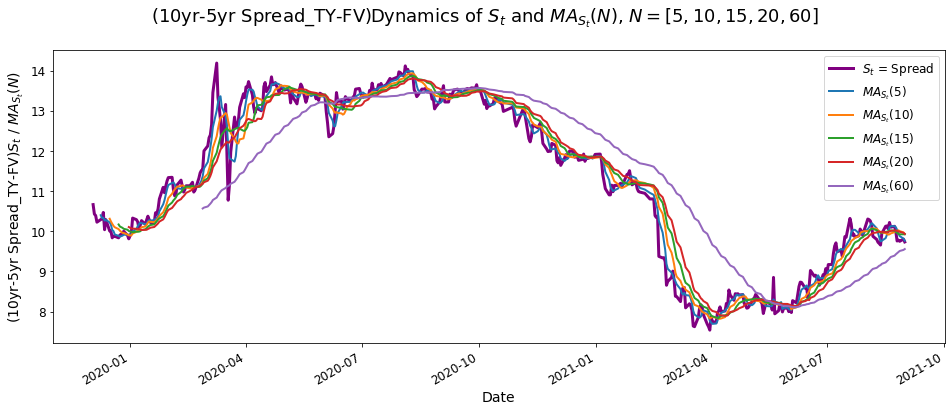

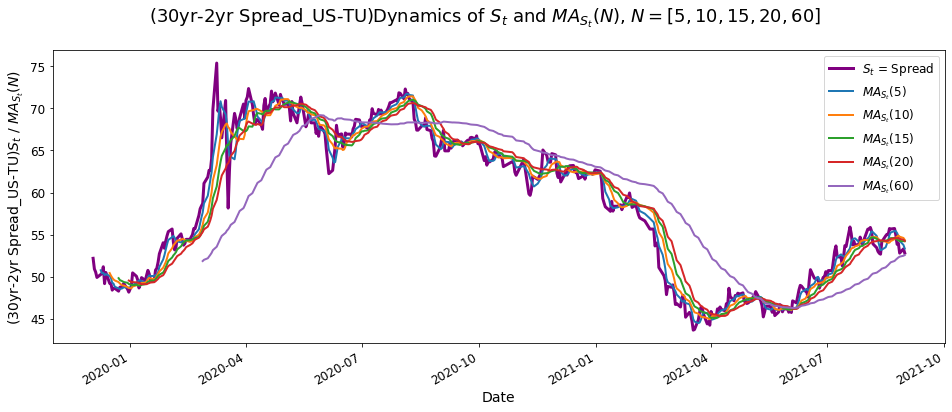

In [6]:
# Spread_TY-FV
plt.figure(figsize=(16,6))
plt.xlabel('Date', fontsize=14)
plt.ylabel('(10yr-5yr Spread_TY-FV)$S_t$ / $MA_{S_t}(N)$', fontsize=14)
plt.suptitle('(10yr-5yr Spread_TY-FV)Dynamics of $S_t$ and $MA_{S_t}(N)$, $N=[5,10,15,20,60]$', fontsize=18)
data_tyfv['Spread_TY-FV'].plot(fontsize=12, label='$S_t$ = Spread', linewidth=3, color='purple')
data_tyfv['TY-FV_MA_5'].plot(label='$MA_{S_t}(5)$', linewidth=2)
data_tyfv['TY-FV_MA_10'].plot(label='$MA_{S_t}(10)$', linewidth=2)
data_tyfv['TY-FV_MA_15'].plot(label='$MA_{S_t}(15)$', linewidth=2)
data_tyfv['TY-FV_MA_20'].plot(label='$MA_{S_t}(20)$', linewidth=2)
data_tyfv['TY-FV_MA_60'].plot(label='$MA_{S_t}(60)$', linewidth=2)
plt.legend(fontsize=12)

# Spread_US-TU
plt.figure(figsize=(16,6))
plt.xlabel('Date', fontsize=14)
plt.ylabel('(30yr-2yr Spread_US-TU)$S_t$ / $MA_{S_t}(N)$', fontsize=14)
plt.suptitle('(30yr-2yr Spread_US-TU)Dynamics of $S_t$ and $MA_{S_t}(N)$, $N=[5,10,15,20,60]$', fontsize=18)
data_ustu['Spread_US-TU'].plot(fontsize=12, label='$S_t$ = Spread', linewidth=3, color='purple')
data_ustu['US-TU_MA_5'].plot(label='$MA_{S_t}(5)$', linewidth=2)
data_ustu['US-TU_MA_10'].plot(label='$MA_{S_t}(10)$', linewidth=2)
data_ustu['US-TU_MA_15'].plot(label='$MA_{S_t}(15)$', linewidth=2)
data_ustu['US-TU_MA_20'].plot(label='$MA_{S_t}(20)$', linewidth=2)
data_ustu['US-TU_MA_60'].plot(label='$MA_{S_t}(60)$', linewidth=2)
plt.legend(fontsize=12)
None

### Summary statistics

**Here we present tables summarizing the key statistics for $S_t$ and $MA_{S_t}^{(N)}$, including mean, median ,standard deviation and quantiles.**

Across the entire period, (10yr-5yr Spread TY-FV) had a mean return of 11.36 with a standard deviation of 20.11. (30yr-2yr Spread TY-FV) had a mean return of 59.62 with a standard deviation of 8.78.

In [7]:
# Spread_TY-FV
summary_statistics = pd.DataFrame(columns=['Mean','Median','Std.Dev','25th Q','50th Q','75th Q','Min','Max','Skewness','Excess Kurtosis','VaR (Quantile 0.05)'])

summary_statistics_tyfv                                        = summary_statistics
summary_statistics_tyfv.loc['(Spread TY-FV)$S_t$']             = table_statistics(data_tyfv,'Spread_TY-FV')
summary_statistics_tyfv.loc['(Spread TY-FV)$MA_{S_t}^{(5)}$']  = table_statistics(data_tyfv,'TY-FV_MA_5')
summary_statistics_tyfv.loc['(Spread TY-FV)$MA_{S_t}^{(10)}$'] = table_statistics(data_tyfv,'TY-FV_MA_10')
summary_statistics_tyfv.loc['(Spread TY-FV)$MA_{S_t}^{(15)}$'] = table_statistics(data_tyfv,'TY-FV_MA_15')
summary_statistics_tyfv.loc['(Spread TY-FV)$MA_{S_t}^{(20)}$'] = table_statistics(data_tyfv,'TY-FV_MA_20')
summary_statistics_tyfv.loc['(Spread TY-FV)$MA_{S_t}^{(60)}$'] = table_statistics(data_tyfv,'TY-FV_MA_60')

summary_statistics_tyfv       

,Mean,Median,Std.Dev,25th Q,50th Q,75th Q,Min,Max,Skewness,Excess Kurtosis,VaR (Quantile 0.05)
(Spread TY-FV)$S_t$,11.362649,11.921875,2.109263,9.343750,11.921875,13.351562,7.539062,14.187500,-0.410485,-1.394686,8.021875
(Spread TY-FV)$MA_{S_t}^{(5)}$,11.371378,11.873437,2.095939,9.426562,11.873437,13.360938,7.695312,13.989062,-0.431014,-1.390122,8.049375
(Spread TY-FV)$MA_{S_t}^{(10)}$,11.379777,11.878125,2.083492,9.356250,11.878125,13.337500,7.821875,13.932813,-0.450305,-1.377270,8.088281
(Spread TY-FV)$MA_{S_t}^{(15)}$,11.387043,11.917188,2.072635,9.380729,11.917188,13.360938,7.840625,13.866667,-0.463280,-1.366697,8.135104
(Spread TY-FV)$MA_{S_t}^{(20)}$,11.394901,11.955859,2.061658,9.431641,11.955859,13.371094,7.896094,13.801562,-0.472434,-1.357452,8.132031
(Spread TY-FV)$MA_{S_t}^{(60)}$,11.437902,12.026302,1.946758,9.383073,12.026302,13.311979,8.111328,13.565625,-0.489933,-1.326851,8.197786


In [8]:
# Spread_US-TU
summary_statistics = pd.DataFrame(columns=['Mean','Median','Std.Dev','25th Q','50th Q','75th Q','Min','Max','Skewness','Excess Kurtosis','VaR (Quantile 0.05)'])

summary_statistics_ustu                                        = summary_statistics
summary_statistics_ustu.loc['(Spread US-TU)$S_t$']             = table_statistics(data_ustu,'Spread_US-TU')
summary_statistics_ustu.loc['(Spread US-TU)$MA_{S_t}^{(5)}$']  = table_statistics(data_ustu,'US-TU_MA_5')
summary_statistics_ustu.loc['(Spread US-TU)$MA_{S_t}^{(10)}$'] = table_statistics(data_ustu,'US-TU_MA_10')
summary_statistics_ustu.loc['(Spread US-TU)$MA_{S_t}^{(15)}$'] = table_statistics(data_ustu,'US-TU_MA_15')
summary_statistics_ustu.loc['(Spread US-TU)$MA_{S_t}^{(20)}$'] = table_statistics(data_ustu,'US-TU_MA_20')
summary_statistics_ustu.loc['(Spread US-TU)$MA_{S_t}^{(60)}$'] = table_statistics(data_ustu,'US-TU_MA_60')

summary_statistics_ustu  

,Mean,Median,Std.Dev,25th Q,50th Q,75th Q,Min,Max,Skewness,Excess Kurtosis,VaR (Quantile 0.05)
(Spread US-TU)$S_t$,59.615957,62.271875,8.778861,50.828125,62.271875,67.412500,43.646875,75.382812,-0.324367,-1.321540,45.792187
(Spread US-TU)$MA_{S_t}^{(5)}$,59.641062,62.228750,8.703600,51.279062,62.228750,67.293438,44.485937,71.737812,-0.356871,-1.333595,45.997250
(Spread US-TU)$MA_{S_t}^{(10)}$,59.650871,62.356250,8.645482,51.506719,62.356250,66.893125,44.944688,71.424688,-0.376198,-1.337106,46.040094
(Spread US-TU)$MA_{S_t}^{(15)}$,59.650704,62.373542,8.597187,51.411146,62.373542,67.117292,45.076771,71.017083,-0.384251,-1.340276,46.060500
(Spread US-TU)$MA_{S_t}^{(20)}$,59.653234,62.613359,8.545976,51.495312,62.613359,66.998437,45.282969,70.638437,-0.388124,-1.342208,46.214953
(Spread US-TU)$MA_{S_t}^{(60)}$,59.562319,61.825000,8.064102,51.382708,61.825000,68.030859,46.274219,69.195130,-0.363852,-1.426752,46.662469


### Correlation

**The correlation table above shows that correlations are high across rolling averages, which can be expected.**

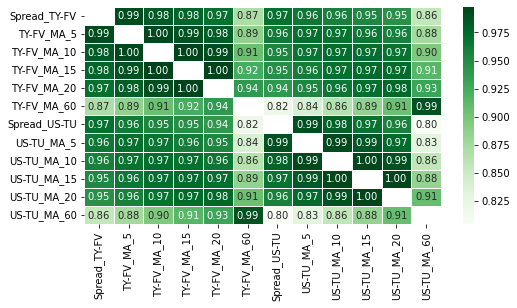

In [9]:
data_tyfv_ustu_MA            = pd.concat([data_tyfv.loc[:,'Spread_TY-FV':'TY-FV_MA_60'],data_ustu.loc[:,'Spread_US-TU':'US-TU_MA_60']],axis=1)
Corr_Table                  = data_tyfv_ustu_MA.corr()
Corr_Table[Corr_Table == 1] = None
plt.figure(figsize = (8,4))
sns.heatmap(Corr_Table,annot=True,fmt = '.2f',cmap='Greens',linewidths=0.5)
None

### Distribution

From the plot with distributions above and from the results of Jarque-Bera test we can say that in spread of futures on 10-y and 5-y US T-Notes and its Moving Averages, i.e. $S_t$ and $MA_{S_t}^{(N)}$ are **NOT Normally Distributed**.<br>
From the plot with distributions above and from the results of Jarque-Bera test we can say that in spread of futures on 30-y and 2-y US T-Notes and its Moving Averages, i.e. $S_t$ and $MA_{S_t}^{(N)}$ are **NOT Normally Distributed**.

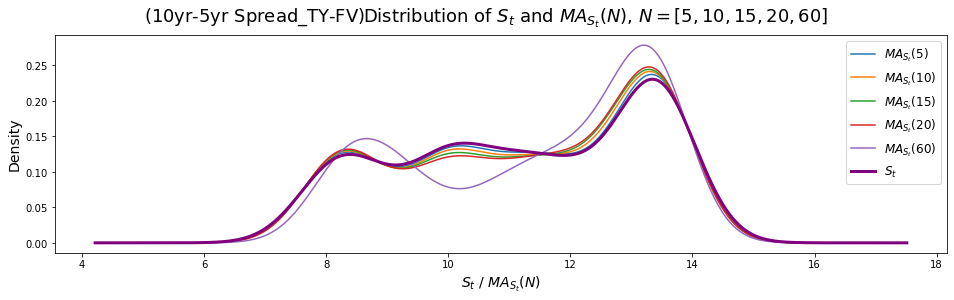

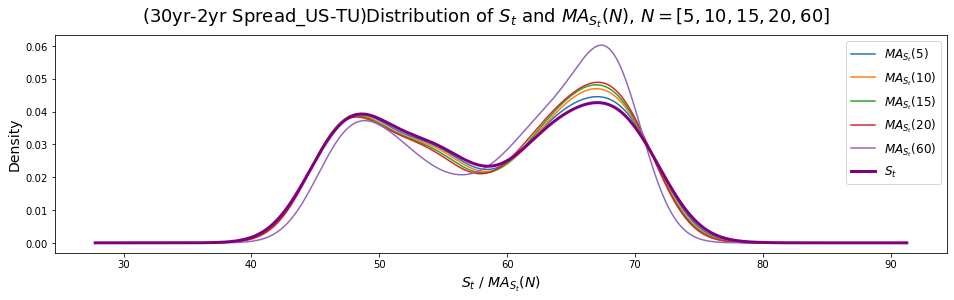

In [10]:
# Spread_TY-FV
plt.figure(figsize=(16,4))
plt.xlabel('$S_t$ / $MA_{S_t}(N)$', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.suptitle('(10yr-5yr Spread_TY-FV)Distribution of $S_t$ and $MA_{S_t}(N)$, $N=[5,10,15,20,60]$', fontsize=18)

data_tyfv['TY-FV_MA_5'].plot.kde(label ='$MA_{S_t}(5)$')
data_tyfv['TY-FV_MA_10'].plot.kde(label='$MA_{S_t}(10)$')
data_tyfv['TY-FV_MA_15'].plot.kde(label='$MA_{S_t}(15)$')
data_tyfv['TY-FV_MA_20'].plot.kde(label='$MA_{S_t}(20)$')
data_tyfv['TY-FV_MA_60'].plot.kde(label='$MA_{S_t}(60)$')
data_tyfv['Spread_TY-FV'].plot.kde(label='$S_t$', linewidth=3, color='purple')

plt.legend(fontsize=12)

# Spread_US-TU
plt.figure(figsize=(16,4))
plt.xlabel('$S_t$ / $MA_{S_t}(N)$', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.suptitle('(30yr-2yr Spread_US-TU)Distribution of $S_t$ and $MA_{S_t}(N)$, $N=[5,10,15,20,60]$', fontsize=18)

data_ustu['US-TU_MA_5'].plot.kde(label ='$MA_{S_t}(5)$')
data_ustu['US-TU_MA_10'].plot.kde(label='$MA_{S_t}(10)$')
data_ustu['US-TU_MA_15'].plot.kde(label='$MA_{S_t}(15)$')
data_ustu['US-TU_MA_20'].plot.kde(label='$MA_{S_t}(20)$')
data_ustu['US-TU_MA_60'].plot.kde(label='$MA_{S_t}(60)$')
data_ustu['Spread_US-TU'].plot.kde(label='$S_t$', linewidth=3, color='purple')

plt.legend(fontsize=12)


None

### Jarque-Bera test

$$H_0: S_t \text{ or } \text{MA}_{S_t}^{(N)} \sim N(\mu, \sigma^2) $$

$$H_a: S_t \text{ or } \text{MA}_{S_t}^{(N)} \not\sim N(\mu, \sigma^2) $$

In [11]:
# Spread_TY-FV
print(jarque_bera(data_tyfv['Spread_TY-FV'].dropna()))
print(jarque_bera(data_tyfv['TY-FV_MA_5'].dropna()))
print(jarque_bera(data_tyfv['TY-FV_MA_10'].dropna()))
print(jarque_bera(data_tyfv['TY-FV_MA_15'].dropna()))
print(jarque_bera(data_tyfv['TY-FV_MA_20'].dropna()))
print(jarque_bera(data_tyfv['TY-FV_MA_60'].dropna()))

# Spread_US-TU
print(jarque_bera(data_ustu['Spread_US-TU'].dropna()))
print(jarque_bera(data_ustu['US-TU_MA_5'].dropna()))
print(jarque_bera(data_ustu['US-TU_MA_10'].dropna()))
print(jarque_bera(data_ustu['US-TU_MA_15'].dropna()))
print(jarque_bera(data_ustu['US-TU_MA_20'].dropna()))
print(jarque_bera(data_ustu['US-TU_MA_60'].dropna()))


Jarque_beraResult(statistic=36.710654628702564, pvalue=1.0675362593914883e-08)
Jarque_beraResult(statistic=37.85793481973682, pvalue=6.015253073421434e-09)
Jarque_beraResult(statistic=38.68017220732176, pvalue=3.9875608370820714e-09)
Jarque_beraResult(statistic=39.25299116920428, pvalue=2.9944789980973496e-09)
Jarque_beraResult(statistic=39.65798835343892, pvalue=2.44555398154489e-09)
Jarque_beraResult(statistic=42.54818393919472, pvalue=5.764734245516934e-10)
Jarque_beraResult(statistic=37.27885189097704, pvalue=8.03526434278723e-09)
Jarque_beraResult(statistic=39.08485911859207, pvalue=3.2570969255019122e-09)
Jarque_beraResult(statistic=39.91485517631731, pvalue=2.1507965408673613e-09)
Jarque_beraResult(statistic=40.206844333026766, pvalue=1.8586374661566651e-09)
Jarque_beraResult(statistic=40.23069584320497, pvalue=1.836603424898442e-09)
Jarque_beraResult(statistic=40.095089892341086, pvalue=1.9654493588205924e-09)


$$ S_t \text{:} \qquad \text{p-value} = 0.00 \Rightarrow \text{ reject } H_0 \text{ that } S_t \sim N(\mu, \sigma^2) $$

$$ MA_{S_t}^{(5)} \text{:} \qquad \text{p-value} = 0.00 \Rightarrow \text{ reject } H_0 \text{ that } MA_{S_t}^{(5)} \sim N(\mu, \sigma^2) $$

$$ MA_{S_t}^{(10)} \text{:} \qquad \text{p-value} = 0.00 \Rightarrow \text{ reject } H_0 \text{ that } MA_{S_t}^{(10)} \sim N(\mu, \sigma^2) $$

$$ MA_{S_t}^{(15)} \text{:} \qquad \text{p-value} = 0.00 \Rightarrow \text{ reject } H_0 \text{ that } MA_{S_t}^{(15)} \sim N(\mu, \sigma^2) $$

$$ MA_{S_t}^{(20)} \text{:} \qquad \text{p-value} = 0.00 \Rightarrow \text{ reject } H_0 \text{ that } MA_{S_t}^{(20)} \sim N(\mu, \sigma^2) $$

$$ MA_{S_t}^{(60)} \text{:} \qquad \text{p-value} = 0.00 \Rightarrow \text{ reject } H_0 \text{ that } MA_{S_t}^{(60)} \sim N(\mu, \sigma^2) $$

### Zero Excess Kurtosis Hypothesis test

From the plot of distributions above as well as from Excess Kurtosis Hypothesis test we can conclude that distribution of spread $S_t$ itself has many outliers.<br>
When using Moving Average with high "window" size outliers did not seem to be smoothed and we can say that distribution of Moving Average of $S_t$ **have fat tails.**

$$H_0: S_t \text{ or } \text{MA}_{S_t}^{(N)} \text{ has Excess Kurtosis equal to ZERO} $$

$$H_a: S_t \text{ or } \text{MA}_{S_t}^{(N)} \text{ has Excess Kurtosis NOT equal to ZERO} $$

In [12]:
# Spread_TY-FV
print(kurtosistest(data_tyfv['Spread_TY-FV'].dropna()))
print(kurtosistest(data_tyfv['TY-FV_MA_5'].dropna()))
print(kurtosistest(data_tyfv['TY-FV_MA_10'].dropna()))
print(kurtosistest(data_tyfv['TY-FV_MA_15'].dropna()))
print(kurtosistest(data_tyfv['TY-FV_MA_20'].dropna()))
print(kurtosistest(data_tyfv['TY-FV_MA_60'].dropna()))
# Spread_US-TU
print(kurtosistest(data_ustu['Spread_US-TU'].dropna()))
print(kurtosistest(data_ustu['US-TU_MA_5'].dropna()))
print(kurtosistest(data_ustu['US-TU_MA_10'].dropna()))
print(kurtosistest(data_ustu['US-TU_MA_15'].dropna()))
print(kurtosistest(data_ustu['US-TU_MA_20'].dropna()))
print(kurtosistest(data_ustu['US-TU_MA_60'].dropna()))

KurtosistestResult(statistic=-26.52821821702181, pvalue=4.5818013010446365e-155)
KurtosistestResult(statistic=-28.53253084205851, pvalue=4.6274812078646544e-179)
KurtosistestResult(statistic=-28.963922212063206, pvalue=1.874292618455383e-184)
KurtosistestResult(statistic=-28.955480926280238, pvalue=2.394032608757021e-184)
KurtosistestResult(statistic=-28.597311566064242, pvalue=7.256366365221882e-180)
KurtosistestResult(statistic=-25.50241065720785, pvalue=1.8535404825369004e-143)
KurtosistestResult(statistic=92.72748189940867, pvalue=0.0)
KurtosistestResult(statistic=72.63394632042368, pvalue=0.0)
KurtosistestResult(statistic=68.36978632772941, pvalue=0.0)
KurtosistestResult(statistic=67.07185877010672, pvalue=0.0)
KurtosistestResult(statistic=67.01678900003351, pvalue=0.0)
KurtosistestResult(statistic=122.39440370082188, pvalue=0.0)


$$ S_t \text{:} \qquad \text{p-value} \approx 0.00 < 0.05 \Rightarrow \text{ reject } H_0 \text{ that } S_t \text{ has Excess Kurtosis equal to zero} $$

$$ MA_{S_t}^{(5)} \text{:} \qquad \text{p-value} \approx 0.00 < 0.05 \Rightarrow \text{ reject } H_0 \text{ that } MA_{S_t}^{(5)} \text{ has Excess Kurtosis equal to zero} $$

$$ MA_{S_t}^{(10)} \text{:} \qquad \text{p-value} \approx 0.00 < 0.05 \Rightarrow \text{ reject } H_0 \text{ that } MA_{S_t}^{(10)} \text{ has Excess Kurtosis equal to zero} $$

$$ MA_{S_t}^{(15)} \text{:} \qquad \text{p-value} \approx 0.00 < 0.05 \Rightarrow \text{ reject } H_0 \text{ that } MA_{S_t}^{(15)} \text{ has Excess Kurtosis equal to zero} $$

$$ MA_{S_t}^{(20)} \text{:} \qquad \text{p-value} \approx 0.00 < 0.05 \Rightarrow \text{ reject } H_0 \text{ that } MA_{S_t}^{(20)} \text{ has Excess Kurtosis equal to zero} $$

$$ MA_{S_t}^{(60)} \text{:} \qquad \text{p-value} \approx 0.00 < 0.05 \Rightarrow \text{ reject } H_0 \text{ that } MA_{S_t}^{(60)} \text{ has Excess Kurtosis equal to zero} $$

### Zero Skewness Hypothesis test

From the plot of distributions above as well as from Skewness Hypothesis test it is obvious that **skewness** of (10yr-5yr Spread TY-FV) $S_t$ as well as of $MA_{S_t}^{(N)}$ is **positive**.<br>
From the plot of distributions above as well as from Skewness Hypothesis test we can conclude that **skewness** of (30yr-2yr Spread TY-FV) $S_t$ as well as of $MA_{S_t}^{(N)}$ depends on the size of the "window" used in calculation of Moving Average. Skewness increases as "window" size increases: $\text{Skewness} \uparrow \text{ as } N \uparrow $.

$$H_0: S_t \text{ or } \text{MA}_{S_t}^{(N)} \text{ has Skewness equal to ZERO} $$

$$H_a: S_t \text{ or } \text{MA}_{S_t}^{(N)} \text{ has Skewness NOT equal to ZERO} $$

In [13]:
# Spread_TY-FV
print(skewtest(data_tyfv['Spread_TY-FV'].dropna()))
print(skewtest(data_tyfv['TY-FV_MA_5'].dropna()))
print(skewtest(data_tyfv['TY-FV_MA_10'].dropna()))
print(skewtest(data_tyfv['TY-FV_MA_15'].dropna()))
print(skewtest(data_tyfv['TY-FV_MA_20'].dropna()))
print(skewtest(data_tyfv['TY-FV_MA_60'].dropna()))

# Spread_US-TU
print(skewtest(data_ustu['Spread_US-TU'].dropna()))
print(skewtest(data_ustu['US-TU_MA_5'].dropna()))
print(skewtest(data_ustu['US-TU_MA_10'].dropna()))
print(skewtest(data_ustu['US-TU_MA_15'].dropna()))
print(skewtest(data_ustu['US-TU_MA_20'].dropna()))
print(skewtest(data_ustu['US-TU_MA_60'].dropna()))


SkewtestResult(statistic=-2.339129266979023, pvalue=0.019328744407661635)
SkewtestResult(statistic=-2.502214570244471, pvalue=0.012341909924310935)
SkewtestResult(statistic=-2.6867987991456492, pvalue=0.0072140392858061776)
SkewtestResult(statistic=-2.834451110244006, pvalue=0.004590448125831698)
SkewtestResult(statistic=-2.959980835823275, pvalue=0.003076581798509819)
SkewtestResult(statistic=-3.748366802221593, pvalue=0.00017798982090905198)
SkewtestResult(statistic=-0.49403372938355844, pvalue=0.6212823588629782)
SkewtestResult(statistic=-0.8067446546052748, pvalue=0.41981361134723993)
SkewtestResult(statistic=-1.0825391591738187, pvalue=0.27901302498802105)
SkewtestResult(statistic=-1.2910323705360642, pvalue=0.1966924530476819)
SkewtestResult(statistic=-1.4732482273561067, pvalue=0.14068411520794577)
SkewtestResult(statistic=-2.843457990554186, pvalue=0.004462689201619638)


$$ (10yr-5yr Spread TY-FV) S_t \text{:} \qquad \text{p-value} \approx 0.02 < 0.05 \Rightarrow \text{ reject } H_0 \text{ that } S_t \text{ has Skewness equal to zero} $$

$$ (10yr-5yr Spread TY-FV) MA_{S_t}^{(5)} \text{:} \qquad \text{p-value} \approx 0.01 < 0.05 \Rightarrow \text{ reject } H_0 \text{ that } MA_{S_t}^{(5)} \text{ has Skewness equal to zero} $$

$$ (10yr-5yr Spread TY-FV) MA_{S_t}^{(10)} \text{:} \qquad \text{p-value} \approx 0.01 < 0.05 \Rightarrow \text{ reject } H_0 \text{ that } MA_{S_t}^{(10)} \text{ has Skewness equal to zero} $$

$$ (10yr-5yr Spread TY-FV) MA_{S_t}^{(15)} \text{:} \qquad \text{p-value} \approx 0.00 < 0.05 \Rightarrow \text{ reject } H_0 \text{ that } MA_{S_t}^{(15)} \text{ has Skewness equal to zero} $$

$$ (10yr-5yr Spread TY-FV) MA_{S_t}^{(20)} \text{:} \qquad \text{p-value} \approx 0.00 < 0.05 \Rightarrow \text{ reject } H_0 \text{ that } MA_{S_t}^{(20)} \text{ has Skewness equal to zero} $$

$$ (10yr-5yr Spread TY-FV) MA_{S_t}^{(60)} \text{:} \qquad \text{p-value} \approx 0.00 < 0.05 \Rightarrow \text{ reject } H_0 \text{ that } MA_{S_t}^{(60)} \text{ has Skewness equal to zero} $$

$$ (30yr-2yr Spread US-TU) S_t \text{:} \qquad \text{p-value} \approx 0.62 > 0.05 \Rightarrow \text{ reject } H_a \text{ that } S_t \text{ has Skewness equal to zero} $$

$$ (30yr-2yr Spread US-TU) MA_{S_t}^{(5)} \text{:} \qquad \text{p-value} \approx 0.42 > 0.05 \Rightarrow \text{ reject } H_a \text{ that } MA_{S_t}^{(5)} \text{ has Skewness not equal to zero} $$

$$ (30yr-2yr Spread US-TU) MA_{S_t}^{(10)} \text{:} \qquad \text{p-value} \approx 0.28 > 0.05 \Rightarrow \text{ reject } H_a \text{ that } MA_{S_t}^{(10)} \text{ has Skewness not equal to zero} $$

$$ (30yr-2yr Spread US-TU) MA_{S_t}^{(15)} \text{:} \qquad \text{p-value} \approx 0.20 > 0.05 \Rightarrow \text{ reject } H_a \text{ that } MA_{S_t}^{(15)} \text{ has Skewness not equal to zero} $$

$$ (30yr-2yr Spread US-TU) MA_{S_t}^{(20)} \text{:} \qquad \text{p-value} \approx 0.14 > 0.05 \Rightarrow \text{ reject } H_a \text{ that } MA_{S_t}^{(20)} \text{ has Skewness not equal to zero} $$

$$ (30yr-2yr Spread US-TU) MA_{S_t}^{(60)} \text{:} \qquad \text{p-value} \approx 0.00 < 0.05 \Rightarrow \text{ reject } H_0 \text{ that } MA_{S_t}^{(60)} \text{ has Skewness equal to zero} $$

### Stationarity check for $S_t$ and $MA_{S_t}^{(N)}, N=[5,10,15,20,60]$

From the Stationarity check it is obvious that (10yr-5yr Spread TY-FV) $S_t$ as well as of $MA_{S_t}^{(N)}$ is **Stationary**.<br>
From the Stationarity check it is obvious that (30yr-2yr Spread TY-FV) $S_t$ as well as of $MA_{S_t}^{(N)}$ is **Stationary**.<br>

$$ H_0: S_t \text{ or } \text{MA}_{S_t}^{(N)} \text{is a unit root process} $$

$$ H_a: S_t \text{ or } \text{MA}_{S_t}^{(N)} \text{is NOT a unit root process} $$

In [14]:
# Spread_TY-FV
print(adfuller(pd.to_numeric(data_tyfv['Spread_TY-FV']).dropna())[1])
print(adfuller(pd.to_numeric(data_tyfv['TY-FV_MA_5']).dropna())[1])
print(adfuller(pd.to_numeric(data_tyfv['TY-FV_MA_10']).dropna())[1])
print(adfuller(pd.to_numeric(data_tyfv['TY-FV_MA_15']).dropna())[1])
print(adfuller(pd.to_numeric(data_tyfv['TY-FV_MA_20']).dropna())[1])
print(adfuller(pd.to_numeric(data_tyfv['TY-FV_MA_60']).dropna())[1])

# Spread_US-TU
      
print(adfuller(pd.to_numeric(data_ustu['Spread_US-TU']).dropna())[1])
print(adfuller(pd.to_numeric(data_ustu['US-TU_MA_5']).dropna())[1])
print(adfuller(pd.to_numeric(data_ustu['US-TU_MA_10']).dropna())[1])
print(adfuller(pd.to_numeric(data_ustu['US-TU_MA_15']).dropna())[1])
print(adfuller(pd.to_numeric(data_ustu['US-TU_MA_20']).dropna())[1])
print(adfuller(pd.to_numeric(data_ustu['US-TU_MA_60']).dropna())[1])

0.8212277024950045
0.6246578614272179
0.6009077555731795
0.35160538209356496
0.5849537775960759
0.016401342153215
0.598293823044841
0.3901344357398254
0.378515042425021
0.21210941842648695
0.29792114593043
0.0991032185410517


$$ (10yr-5yr Spread TY-FV)S_t \text{:} \qquad \text{p-value} \approx 0.82 > 0.05 \Rightarrow \text{ reject } H_a \text{ that } S_t \text{ doesn't have a unit root} \Rightarrow S_t \text{ is STATIONARY} $$

$$ (10yr-5yr Spread TY-FV)MA_{S_t}^{(5)} \text{:} \qquad \text{p-value} \approx 0.62 > 0.05 \Rightarrow \text{ reject } H_a \text{ that } MA_{S_t}^{(5)} \text{ doesn't have a unit root} \Rightarrow MA_{S_t}^{(5)} \text{ is STATIONARY} $$

$$ (10yr-5yr Spread TY-FV)MA_{S_t}^{(10)} \text{:} \qquad \text{p-value} \approx 0.60 > 0.05 \Rightarrow \text{ reject } H_a \text{ that } MA_{S_t}^{(10)} \text{ doesn't have a unit root} \Rightarrow MA_{S_t}^{(10)} \text{ is STATIONARY} $$

$$ (10yr-5yr Spread TY-FV)MA_{S_t}^{(15)} \text{:} \qquad \text{p-value} \approx 0.35 > 0.05 \Rightarrow \text{ reject } H_a \text{ that } MA_{S_t}^{(15)}\text{ doesn't have a unit root} \Rightarrow MA_{S_t}^{(15)} \text{ is STATIONARY} $$

$$ (10yr-5yr Spread TY-FV)MA_{S_t}^{(20)} \text{:} \qquad \text{p-value} \approx 0.58 > 0.05 \Rightarrow \text{ reject } H_a \text{ that } MA_{S_t}^{(20)}\text{ doesn't have a unit root} \Rightarrow MA_{S_t}^{(20)} \text{ is STATIONARY} $$
                                                                                                                             
$$ (10yr-5yr Spread TY-FV)MA_{S_t}^{(60)} \text{:} \qquad \text{p-value} \approx 0.2 < 0.05 \Rightarrow \text{ reject } H_0 \text{ that } MA_{S_t}^{(60)} \text{ has a unit root} \Rightarrow MA_{S_t}^{(60)} \text{ is NOT STATIONARY} $$

$$ (30yr-2yr Spread US-TU)S_t \text{:} \qquad \text{p-value} \approx 0.60 > 0.05 \Rightarrow \text{ reject } H_a \text{ that } S_t \text{ doesn't have a unit root} \Rightarrow S_t \text{ is STATIONARY} $$

$$ (30yr-2yr Spread US-TU)MA_{S_t}^{(5)} \text{:} \qquad \text{p-value} \approx 0.40 > 0.05 \Rightarrow \text{ reject } H_a \text{ that } MA_{S_t}^{(5)} \text{ doesn't have a unit root} \Rightarrow MA_{S_t}^{(5)} \text{ is STATIONARY} $$

$$ (30yr-2yr Spread US-TU)MA_{S_t}^{(10)} \text{:} \qquad \text{p-value} \approx 0.38 > 0.05 \Rightarrow \text{ reject } H_a \text{ that } MA_{S_t}^{(10)} \text{ doesn't have a unit root} \Rightarrow MA_{S_t}^{(10)} \text{ is STATIONARY} $$

$$ (30yr-2yr Spread US-TU)MA_{S_t}^{(15)} \text{:} \qquad \text{p-value} \approx 0.21 > 0.05 \Rightarrow \text{ reject } H_a \text{ that } MA_{S_t}^{(15)}\text{ doesn't have a unit root} \Rightarrow MA_{S_t}^{(15)} \text{ is STATIONARY} $$

$$ (30yr-2yr Spread US-TU)MA_{S_t}^{(20)} \text{:} \qquad \text{p-value} \approx 0.30 > 0.05 \Rightarrow \text{ reject } H_a \text{ that } MA_{S_t}^{(20)}\text{ doesn't have a unit root} \Rightarrow MA_{S_t}^{(20)} \text{ is STATIONARY} $$
                                                                                                                             
$$ (30yr-2yr Spread US-TU)MA_{S_t}^{(60)} \text{:} \qquad \text{p-value} \approx 0.10 > 0.05 \Rightarrow \text{ reject } H_a \text{ that } MA_{S_t}^{(60)}\text{ doesn't have a unit root} \Rightarrow MA_{S_t}^{(20)} \text{ is STATIONARY} $$


### Seasonality decomposition of $MA_{S_t}^{(5)}$ and $MA_{S_t}^{(20)}$

From the plot of $S_t$ and $MA_{S_t}^{(N)}$ dynamics as well as from "Stationarity check" and "Seasonality decomposition" above we can conclude that spread $S_t$ itself as well as its Moving Averages are **stationary**. We can also conclude that in both $S_t$ and $MA_{S_t}^{(N)}$ present very small seasonal "component".

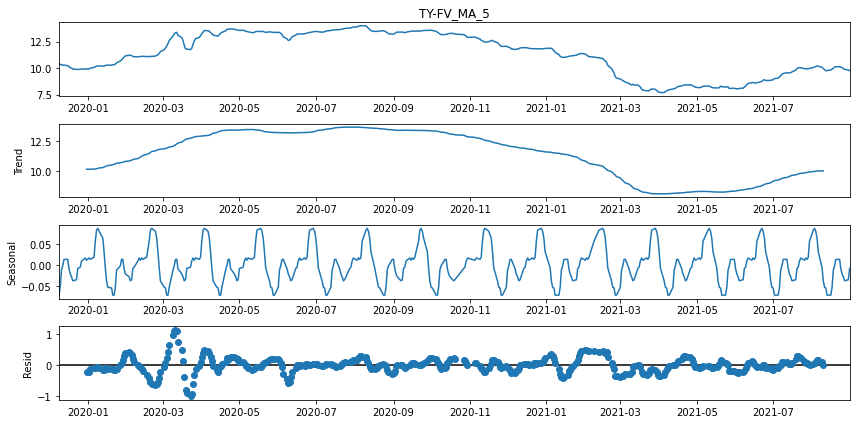

In [15]:
# Spread_TY-FV
seasonality_decomposition5 = sm.tsa.seasonal_decompose((pd.to_numeric(data_tyfv['TY-FV_MA_5']).dropna()), model='additive', freq=30)
                                                        
plt.rcParams['figure.figsize'] = [12,6]
plt.rcParams.update({'font.size': 10})
seasonality_decomposition5.plot()
None                                                        

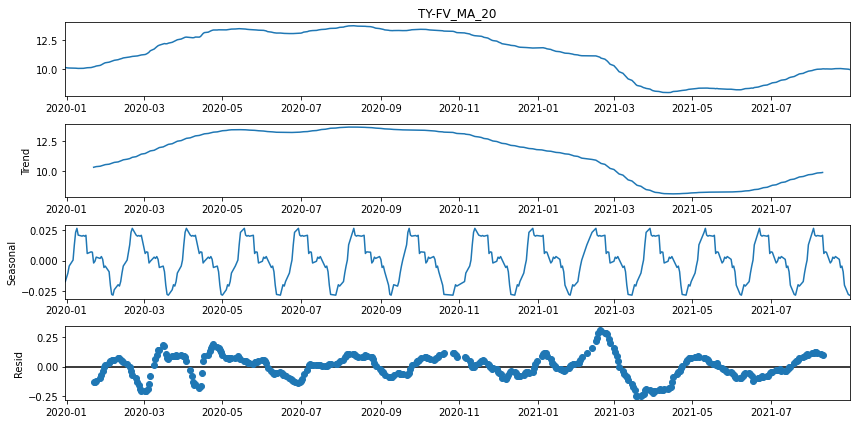

In [16]:
# Spread_TY-FV
seasonality_decomposition20 = sm.tsa.seasonal_decompose((pd.to_numeric(data_tyfv['TY-FV_MA_20']).dropna()), model='additive', freq=30)
                                                        
plt.rcParams['figure.figsize'] = [12,6]
plt.rcParams.update({'font.size': 10})
seasonality_decomposition20.plot()
None                     

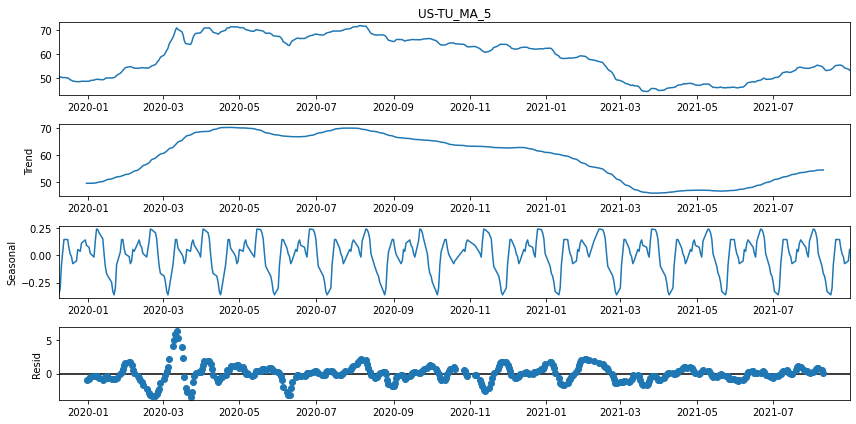

In [17]:
# Spread_US-TU
seasonality_decomposition5 = sm.tsa.seasonal_decompose((pd.to_numeric(data_ustu['US-TU_MA_5']).dropna()), model='additive', freq=30)
                                                        
plt.rcParams['figure.figsize'] = [12,6]
plt.rcParams.update({'font.size': 10})
seasonality_decomposition5.plot()
None 

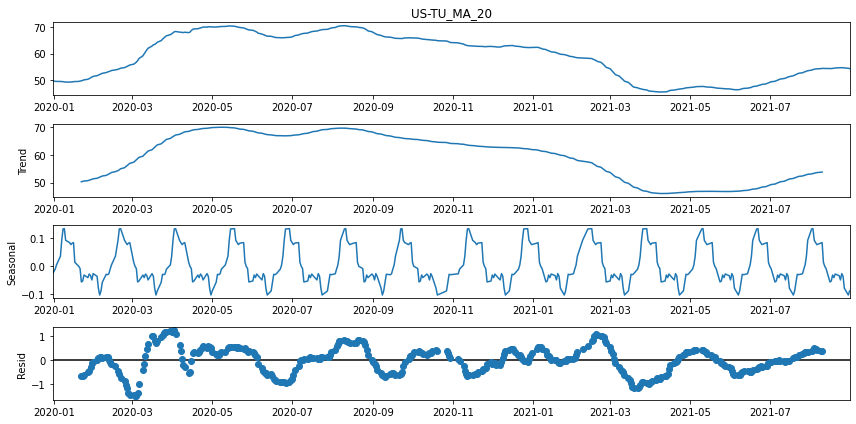

In [18]:
# Spread_US-TU
seasonality_decomposition20 = sm.tsa.seasonal_decompose((pd.to_numeric(data_ustu['US-TU_MA_20']).dropna()), model='additive', freq=30)
                                                        
plt.rcParams['figure.figsize'] = [12,6]
plt.rcParams.update({'font.size': 10})
seasonality_decomposition20.plot()
None 

# 3. Analysis of $d_t^{(N)}, N=[5,10,15,20,60]$

**We will set rolling averages to span over one week, two weeks, three weeks, one month and one quarter observations. (We assume 253 trading days in a year)**

The two futures spreads analyzed are:
* [10-Year T-Note Futures](https://www.cmegroup.com/trading/interest-rates/us-treasury/10-year-us-treasury-note_contractSpecs_futures.html) over the [5-Year T-Note Futures](https://www.cmegroup.com/trading/interest-rates/us-treasury/5-year-us-treasury-note_contractSpecs_futures.html) (Spread_TY-FV throughout)
* [30-Year T-Note Futures](https://www.cmegroup.com/markets/interest-rates/us-treasury/30-year-us-treasury-bond.contractSpecs.html) over the [2-Year T-Note Futures](https://www.cmegroup.com/markets/interest-rates/us-treasury/2-year-us-treasury-note.contractSpecs.html) (Spread_US-TU throughout)

Discussion and analysis of the following exhibits is included:
* Spread charts
* Summary statistics
* Correlation
* Distribution
* Tail and skewness
* Stationarity checks
* Seasonality decomposition

### Spread charts

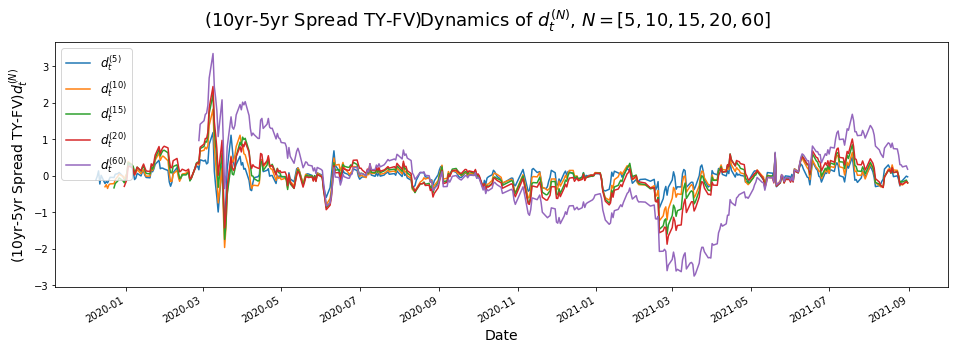

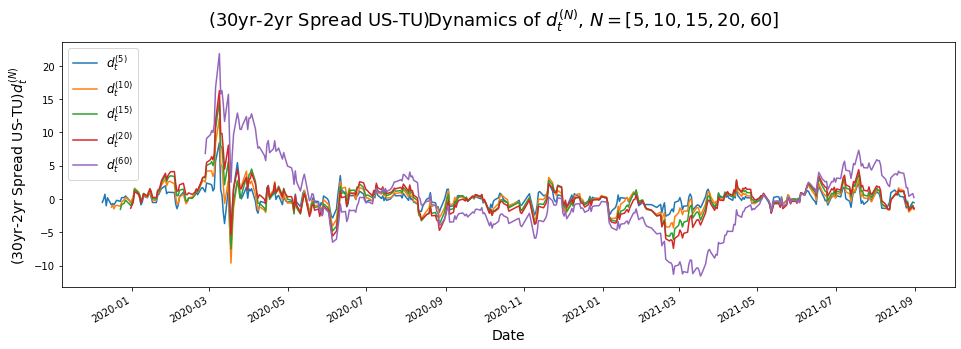

In [19]:
# Spread_TY-FV
plt.figure(figsize=(16,5))
plt.xlabel('Date', fontsize=14)
plt.ylabel('(10yr-5yr Spread TY-FV)$d_t^{(N)}$', fontsize=14)
plt.suptitle('(10yr-5yr Spread TY-FV)Dynamics of $d_t^{(N)}$, $N=[5,10,15,20,60]$', fontsize=18)
data_tyfv['TY-FV_Diff_5'].plot(label='$d_t^{(5)}$')
data_tyfv['TY-FV_Diff_10'].plot(label='$d_t^{(10)}$')
data_tyfv['TY-FV_Diff_15'].plot(label='$d_t^{(15)}$')
data_tyfv['TY-FV_Diff_20'].plot(label='$d_t^{(20)}$')
data_tyfv['TY-FV_Diff_60'].plot(label='$d_t^{(60)}$')
plt.legend(fontsize=12)

# Spread_US-TU
plt.figure(figsize=(16,5))
plt.xlabel('Date', fontsize=14)
plt.ylabel('(30yr-2yr Spread US-TU)$d_t^{(N)}$', fontsize=14)
plt.suptitle('(30yr-2yr Spread US-TU)Dynamics of $d_t^{(N)}$, $N=[5,10,15,20,60]$', fontsize=18)
data_ustu['US-TU_Diff_5'].plot(label='$d_t^{(5)}$')
data_ustu['US-TU_Diff_10'].plot(label='$d_t^{(10)}$')
data_ustu['US-TU_Diff_15'].plot(label='$d_t^{(15)}$')
data_ustu['US-TU_Diff_20'].plot(label='$d_t^{(20)}$')
data_ustu['US-TU_Diff_60'].plot(label='$d_t^{(60)}$')
plt.legend(fontsize=12)
None

### Summary statistics

**Here we present tables summarizing the key statistics for $d_t^{(N)}$, including mean, median ,standard deviation and quantiles.**

Across the entire period, (10yr-5yr Spread TY-FV) minus 5 tradging day moving average had a mean return of -0.009 with a standard deviation of 0.25. (30yr-2yr Spread TY-FV) minus 5 tradging day moving average had a mean return of -0.025 with a standard deviation of 1.25.

In [20]:
# Spread_TY-FV
summary_statistics = pd.DataFrame(columns=['Mean','Median','Std.Dev','25th Q','50th Q','75th Q','Min','Max','Skewness','Excess Kurtosis','VaR (Quantile 0.05)'])

summary_statistics_tyfv                                   = summary_statistics
summary_statistics_tyfv.loc['(Spread TY-FV)$d_t^{(5)}$'] = table_statistics(data_tyfv,'TY-FV_Diff_5')
summary_statistics_tyfv.loc['(Spread TY-FV)$d_t^{(10)}$'] = table_statistics(data_tyfv,'TY-FV_Diff_10')
summary_statistics_tyfv.loc['(Spread TY-FV)$d_t^{(15)}$'] = table_statistics(data_tyfv,'TY-FV_Diff_15')
summary_statistics_tyfv.loc['(Spread TY-FV)$d_t^{(20)}$'] = table_statistics(data_tyfv,'TY-FV_Diff_20')
summary_statistics_tyfv.loc['(Spread TY-FV)$d_t^{(60)}$'] = table_statistics(data_tyfv,'TY-FV_Diff_60')

summary_statistics_tyfv       

,Mean,Median,Std.Dev,25th Q,50th Q,75th Q,Min,Max,Skewness,Excess Kurtosis,VaR (Quantile 0.05)
(Spread TY-FV)$d_t^{(5)}$,-0.008728,0.001563,0.245914,-0.118750,0.001563,0.110938,-1.368750,1.182813,-0.136918,5.710422,-0.373750
(Spread TY-FV)$d_t^{(10)}$,-0.017127,0.004687,0.359839,-0.196875,0.004687,0.146094,-1.967969,1.822656,-0.260546,5.398050,-0.578906
(Spread TY-FV)$d_t^{(15)}$,-0.024394,-0.006250,0.434774,-0.209375,-0.006250,0.188021,-1.746354,2.232812,-0.033699,3.969202,-0.724583
(Spread TY-FV)$d_t^{(20)}$,-0.032252,0.005859,0.500657,-0.273047,0.005859,0.237500,-1.878516,2.444531,-0.147076,3.096614,-0.826406
(Spread TY-FV)$d_t^{(60)}$,-0.075253,-0.039193,1.049975,-0.716016,-0.039193,0.595833,-2.751042,3.347396,-0.225860,0.231599,-2.126615


In [21]:
# Spread_US-TU
summary_statistics = pd.DataFrame(columns=['Mean','Median','Std.Dev','25th Q','50th Q','75th Q','Min','Max','Skewness','Excess Kurtosis','VaR (Quantile 0.05)'])

summary_statistics_ustu                                   = summary_statistics
summary_statistics_ustu.loc['(Spread US-TU)$d_t^{(5)}$'] = table_statistics(data_ustu,'US-TU_Diff_5')
summary_statistics_ustu.loc['(Spread US-TU)$d_t^{(10)}$'] = table_statistics(data_ustu,'US-TU_Diff_10')
summary_statistics_ustu.loc['(Spread US-TU)$d_t^{(15)}$'] = table_statistics(data_ustu,'US-TU_Diff_15')
summary_statistics_ustu.loc['(Spread US-TU)$d_t^{(20)}$'] = table_statistics(data_ustu,'US-TU_Diff_20')
summary_statistics_ustu.loc['(Spread US-TU)$d_t^{(60)}$'] = table_statistics(data_ustu,'US-TU_Diff_60')

summary_statistics_ustu              

,Mean,Median,Std.Dev,25th Q,50th Q,75th Q,Min,Max,Skewness,Excess Kurtosis,VaR (Quantile 0.05)
(Spread US-TU)$d_t^{(5)}$,-0.025105,0.027500,1.251757,-0.646875,0.027500,0.586562,-7.496250,8.486875,0.583766,10.362126,-1.828313
(Spread US-TU)$d_t^{(10)}$,-0.034914,0.089687,1.789421,-0.911719,0.089687,0.767656,-9.612656,12.126719,0.654486,8.523224,-2.693938
(Spread US-TU)$d_t^{(15)}$,-0.034747,-0.006354,2.194612,-1.191458,-0.006354,1.043333,-7.482500,14.669896,1.108818,7.268846,-3.352167
(Spread US-TU)$d_t^{(20)}$,-0.037277,-0.034766,2.568086,-1.415859,-0.034766,1.311953,-7.405938,16.264922,1.063206,6.255594,-4.190375
(Spread US-TU)$d_t^{(60)}$,0.053638,-0.747083,5.311437,-2.837786,-0.747083,2.917135,-11.558828,21.827552,0.573976,1.122930,-9.228750


### Correlation

**The correlation table above shows that correlations are high across rolling averages. However, when the moving average window difference becomes larger, the amount of correlation will decrease.**

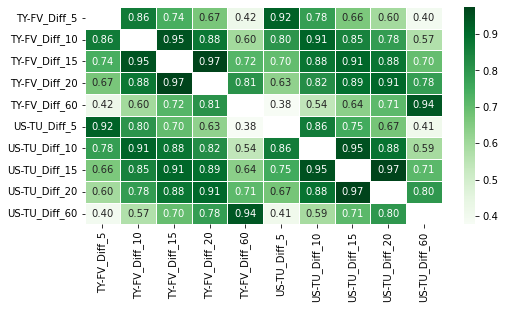

In [22]:
data_tyfv_ustu_Diff         = pd.concat([data_tyfv.loc[:,'TY-FV_Diff_5':'TY-FV_Diff_60'],data_ustu.loc[:,'US-TU_Diff_5':'US-TU_Diff_60']],axis=1)
Corr_Table                  = data_tyfv_ustu_Diff.corr()
Corr_Table[Corr_Table == 1] = None
plt.figure(figsize = (8,4))
sns.heatmap(Corr_Table,annot=True,fmt = '.2f',cmap='Greens',linewidths=0.5)
None

### Distribution

From the plot with distributions above and from the results of Jarque-Bera test we can say that in general differences between spread of futures on **10yr** and **5yr** US T-Notes and its Moving Averages, i.e. $d_t^{(N)}$ are **NOT Normally Distributed**.<br> 
$d_t^{(N)}$ **approaches Normal Distribution** as the size of the "window" used in calculation of Moving Average increases (in reasonable manner): $d_t^{(N)} \rightarrow \mathcal{N}(\mu, \sigma^2) \text{ as } N \uparrow $.

From the plot with distributions above and from the results of Jarque-Bera test we can say that in general differences between spread of futures on **30yr** and **2yr** US T-Notes and its Moving Averages, i.e. $d_t^{(N)}$ are **NOT Normally Distributed**.<br> 
$d_t^{(N)}$ **approaches Normal Distribution** as the size of the "window" used in calculation of Moving Average increases (in reasonable manner): $d_t^{(N)} \rightarrow \mathcal{N}(\mu, \sigma^2) \text{ as } N \uparrow $.

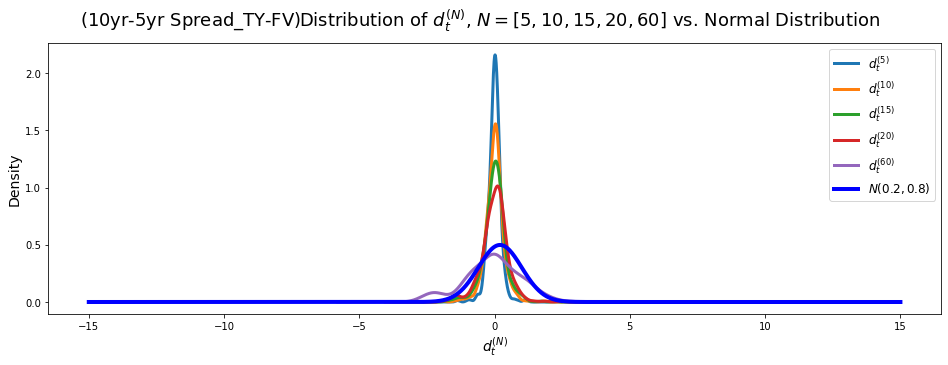

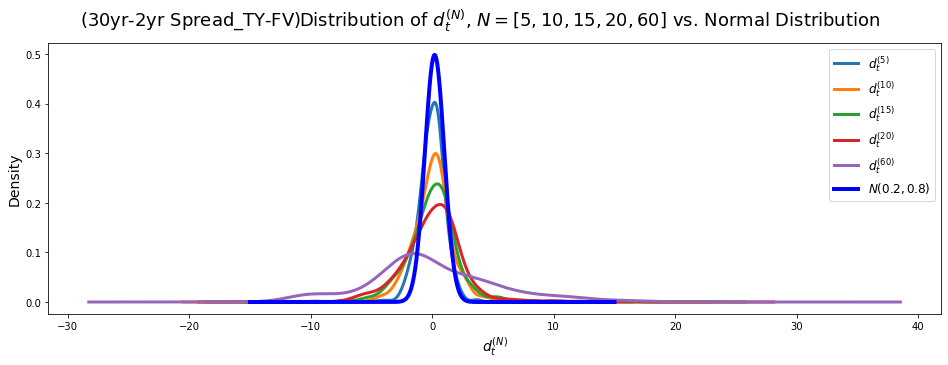

In [23]:
# Spread_TY-FV
plt.figure(figsize=(16,5))
plt.xlabel('$d_t^{(N)}$', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.suptitle('(10yr-5yr Spread_TY-FV)Distribution of $d_t^{(N)}$, $N=[5,10,15,20,60]$ vs. Normal Distribution', fontsize=18)

data_tyfv['TY-FV_Diff_5'].plot.kde(label='$d_t^{(5)}$', linewidth=3)
data_tyfv['TY-FV_Diff_10'].plot.kde(label='$d_t^{(10)}$', linewidth=3)
data_tyfv['TY-FV_Diff_15'].plot.kde(label='$d_t^{(15)}$', linewidth=3)
data_tyfv['TY-FV_Diff_20'].plot.kde(label='$d_t^{(20)}$', linewidth=3)
data_tyfv['TY-FV_Diff_60'].plot.kde(label='$d_t^{(60)}$', linewidth=3)

n = 15
plt.plot(np.linspace(-n, n, 1000), norm.pdf(np.linspace(-n, n, 1000), 0.2, 0.8), 
         label='$N(0.2, 0.8)$', linewidth=4, color='blue')

plt.legend(fontsize=12)

# Spread_US-TU
plt.figure(figsize=(16,5))
plt.xlabel('$d_t^{(N)}$', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.suptitle('(30yr-2yr Spread_TY-FV)Distribution of $d_t^{(N)}$, $N=[5,10,15,20,60]$ vs. Normal Distribution', fontsize=18)

data_ustu['US-TU_Diff_5'].plot.kde(label='$d_t^{(5)}$', linewidth=3)
data_ustu['US-TU_Diff_10'].plot.kde(label='$d_t^{(10)}$', linewidth=3)
data_ustu['US-TU_Diff_15'].plot.kde(label='$d_t^{(15)}$', linewidth=3)
data_ustu['US-TU_Diff_20'].plot.kde(label='$d_t^{(20)}$', linewidth=3)
data_ustu['US-TU_Diff_60'].plot.kde(label='$d_t^{(60)}$', linewidth=3)

n = 15
plt.plot(np.linspace(-n, n, 1000), norm.pdf(np.linspace(-n, n, 1000), 0.2, 0.8), 
         label='$N(0.2, 0.8)$', linewidth=4, color='blue')

plt.legend(fontsize=12)
None

### Jarque-Bera test

$$H_0: d_t^{(N)} \sim(\mu, \sigma^2) $$

$$H_a: d_t^{(N)} \not\sim(\mu, \sigma^2) $$

In [24]:
# Spread_TY-FV
print(jarque_bera(data_tyfv['TY-FV_Diff_5'].dropna()))
print(jarque_bera(data_tyfv['TY-FV_Diff_10'].dropna()))
print(jarque_bera(data_tyfv['TY-FV_Diff_15'].dropna()))
print(jarque_bera(data_tyfv['TY-FV_Diff_20'].dropna()))
print(jarque_bera(data_tyfv['TY-FV_Diff_60'].dropna()))

# Spread_US-TU
print(jarque_bera(data_ustu['US-TU_Diff_5'].dropna()))
print(jarque_bera(data_ustu['US-TU_Diff_10'].dropna()))
print(jarque_bera(data_ustu['US-TU_Diff_15'].dropna()))
print(jarque_bera(data_ustu['US-TU_Diff_20'].dropna()))
print(jarque_bera(data_ustu['US-TU_Diff_60'].dropna()))

Jarque_beraResult(statistic=614.0034436108983, pvalue=0.0)
Jarque_beraResult(statistic=531.6936269263706, pvalue=0.0)
Jarque_beraResult(statistic=274.7201934404633, pvalue=0.0)
Jarque_beraResult(statistic=165.54720148764696, pvalue=0.0)
Jarque_beraResult(statistic=3.8902503446945906, pvalue=0.1429693264118379)
Jarque_beraResult(statistic=1937.9020842885288, pvalue=0.0)
Jarque_beraResult(statistic=1231.3420423545124, pvalue=0.0)
Jarque_beraResult(statistic=895.2186177400757, pvalue=0.0)
Jarque_beraResult(statistic=641.1145280813113, pvalue=0.0)
Jarque_beraResult(statistic=39.27490954273663, pvalue=2.961841105708629e-09)


$$ (10yr-5yr Spread TY-FV) d_t^{(5)} \text{:} \qquad \text{p-value} \approx 0.00 < 0.05 \Rightarrow \text{ reject } H_0 \text{ that } d_t^{(5)} \sim \mathcal{N}(\mu, \sigma^2) $$

$$ (10yr-5yr Spread TY-FV) d_t^{(10)} \text{:} \qquad \text{p-value} \approx 0.00 < 0.05 \Rightarrow \text{ reject } H_0 \text{ that } d_t^{(10)} \sim \mathcal{N}(\mu, \sigma^2) $$

$$ (10yr-5yr Spread TY-FV) d_t^{(15)} \text{:} \qquad \text{p-value} \approx 0.00 < 0.05 \Rightarrow \text{ reject } H_0 \text{ that } d_t^{(15)} \sim \mathcal{N}(\mu, \sigma^2) $$

$$ (10yr-5yr Spread TY-FV) d_t^{(20)} \text{:} \qquad \text{p-value} \approx 0.00 < 0.05 \Rightarrow \text{ reject } H_0 \text{ that } d_t^{(20)} \sim \mathcal{N}(\mu, \sigma^2) $$

$$ (10yr-5yr Spread TY-FV) d_t^{(60)} \text{:} \qquad \text{p-value} \approx 0.14 > 0.05 \Rightarrow \text{ reject } H_a \text{ that } d_t^{(60)} \not\sim \mathcal{N}(\mu, \sigma^2) $$

$$ (30yr-2yr Spread TY-FV) d_t^{(5)} \text{:} \qquad \text{p-value} \approx 0.00 < 0.05 \Rightarrow \text{ reject } H_0 \text{ that } d_t^{(5)} \sim \mathcal{N}(\mu, \sigma^2) $$

$$ (30yr-2yr Spread TY-FV) d_t^{(10)} \text{:} \qquad \text{p-value} \approx 0.00 < 0.05 \Rightarrow \text{ reject } H_0 \text{ that } d_t^{(10)} \sim \mathcal{N}(\mu, \sigma^2) $$

$$ (30yr-2yr Spread TY-FV) d_t^{(15)} \text{:} \qquad \text{p-value} \approx 0.00 < 0.05 \Rightarrow \text{ reject } H_0 \text{ that } d_t^{(15)} \sim \mathcal{N}(\mu, \sigma^2) $$

$$ (30yr-2yr Spread TY-FV) d_t^{(20)} \text{:} \qquad \text{p-value} \approx 0.00 < 0.05 \Rightarrow \text{ reject } H_0 \text{ that } d_t^{(20)} \sim \mathcal{N}(\mu, \sigma^2) $$

$$ (30yr-2yr Spread TY-FV) d_t^{(60)} \text{:} \qquad \text{p-value} \approx 2.96 > 0.05 \Rightarrow \text{ reject } H_a \text{ that } d_t^{(60)} \not\sim \mathcal{N}(\mu, \sigma^2) $$

### Zero Excess Kurtosis Hypothesis test

From the plot of distributions above as well as from Excess Kurtosis Hypothesis test we can conclude that $(10yr-5yr Spread TY-FV)d_t^{(N)}$ **have FAT TAILS**, i.e. $d_t^{(N)}$ have many outliers.

From the plot of distributions above as well as from Excess Kurtosis Hypothesis test we can conclude that $(30yr-2yr Spread US-TU)d_t^{(N)}$ **have FAT TAILS**, i.e. $d_t^{(N)}$ have many outliers.

$$H_0: d_t^{(N)} \text{ has Excess Kurtosis equal to ZERO} $$

$$H_a: d_t^{(N)} \text{ has Excess Kurtosis NOT equal to ZERO} $$

In [25]:
# Spread_TY-FV
print(kurtosistest(data_tyfv['TY-FV_Diff_5'].dropna()))
print(kurtosistest(data_tyfv['TY-FV_Diff_10'].dropna()))
print(kurtosistest(data_tyfv['TY-FV_Diff_15'].dropna()))
print(kurtosistest(data_tyfv['TY-FV_Diff_20'].dropna()))
print(kurtosistest(data_tyfv['TY-FV_Diff_60'].dropna()))

# Spread_US-TU
print(kurtosistest(data_ustu['US-TU_Diff_5'].dropna()))
print(kurtosistest(data_ustu['US-TU_Diff_10'].dropna()))
print(kurtosistest(data_ustu['US-TU_Diff_15'].dropna()))
print(kurtosistest(data_ustu['US-TU_Diff_20'].dropna()))
print(kurtosistest(data_ustu['US-TU_Diff_60'].dropna()))

KurtosistestResult(statistic=7.873508909445732, pvalue=3.4483051456775186e-15)
KurtosistestResult(statistic=7.634564866535681, pvalue=2.2658438719558063e-14)
KurtosistestResult(statistic=6.684660110738651, pvalue=2.3146121739823366e-11)
KurtosistestResult(statistic=5.920543452714206, pvalue=3.208794969194877e-09)
KurtosistestResult(statistic=0.9676964418483007, pvalue=0.3331959956686581)
KurtosistestResult(statistic=9.451087380356942, pvalue=3.3532882633774726e-21)
KurtosistestResult(statistic=8.797927492838719, pvalue=1.3936603413739935e-18)
KurtosistestResult(statistic=8.24998364603599, pvalue=1.5841620374866792e-16)
KurtosistestResult(statistic=7.738351776737084, pvalue=1.0071387109213158e-14)
KurtosistestResult(statistic=3.177594136543098, pvalue=0.001485024724187522)


$$ (10yr-5yr Spread TY-FV) d_t^{(5)} \text{:} \qquad \text{p-value} \approx 0.00 < 0.05 \Rightarrow \text{ reject } H_0 \text{ that } d_t^{(5)} \text{ has Excess Kurtosis equal to zero} $$

$$ (10yr-5yr Spread TY-FV) d_t^{(10)} \text{:} \qquad \text{p-value} \approx 0.00 < 0.05 \Rightarrow \text{ reject } H_0 \text{ that } d_t^{(10)} \text{ has Excess Kurtosis equal to zero} $$

$$ (10yr-5yr Spread TY-FV) d_t^{(15)} \text{:} \qquad \text{p-value} \approx 0.00 < 0.05 \Rightarrow \text{ reject } H_0 \text{ that } d_t^{(15)} \text{ has Excess Kurtosis equal to zero} $$

$$ (10yr-5yr Spread TY-FV) d_t^{(20)} \text{:} \qquad \text{p-value} \approx 0.00 < 0.05 \Rightarrow \text{ reject } H_0 \text{ that } d_t^{(20)} \text{ has Excess Kurtosis equal to zero} $$

$$ (10yr-5yr Spread TY-FV) d_t^{(60)} \text{:} \qquad \text{p-value} \approx 0.33 > 0.05 \Rightarrow \text{ reject } H_a \text{ that } d_t^{(60)} \text{ has Excess Kurtosis not equal to zero} $$

$$ (30yr-2yr Spread US-TU) d_t^{(5)} \text{:} \qquad \text{p-value} \approx 0.00 < 0.05 \Rightarrow \text{ reject } H_0 \text{ that } d_t^{(5)} \text{ has Excess Kurtosis equal to zero} $$

$$ (30yr-2yr Spread US-TU) d_t^{(10)} \text{:} \qquad \text{p-value} \approx 0.00 < 0.05 \Rightarrow \text{ reject } H_0 \text{ that } d_t^{(10)} \text{ has Excess Kurtosis equal to zero} $$

$$ (30yr-2yr Spread US-TU) d_t^{(15)} \text{:} \qquad \text{p-value} \approx 0.00 < 0.05 \Rightarrow \text{ reject } H_0 \text{ that } d_t^{(15)} \text{ has Excess Kurtosis equal to zero} $$

$$ (30yr-2yr Spread US-TU) d_t^{(20)} \text{:} \qquad \text{p-value} \approx 0.00 < 0.05 \Rightarrow \text{ reject } H_0 \text{ that } d_t^{(20)} \text{ has Excess Kurtosis equal to zero} $$

$$ (30yr-2yr Spread US-TU) d_t^{(60)} \text{:} \qquad \text{p-value} \approx 0.00 < 0.05 \Rightarrow \text{ reject } H_0 \text{ that } d_t^{(60)} \text{ has Excess Kurtosis equal to zero} $$

### Zero Skewness Hypothesis test

From the plot of distributions above as well as from Skewness Hypothesis test we can conclude that skewness of $(10yr-5yr Spread TY-FV)d_t^{(N)}$ is equal to zero.<br>
From the plot of distributions above as well as from Skewness Hypothesis test it is obvious that **skewness** of $(30yr-2yr Spread TY-FV)S_t$ as well as of $MA_{S_t}^{(N)}$ is **positive**.

$$H_0: d_t^{(N)} \text{ has Skewness equal to ZERO} $$

$$H_a: d_t^{(N)} \text{ has Skewness NOT equal to ZERO} $$

In [26]:
# Spread_TY-FV
print(skewtest(data_tyfv['TY-FV_Diff_5'].dropna()))
print(skewtest(data_tyfv['TY-FV_Diff_10'].dropna()))
print(skewtest(data_tyfv['TY-FV_Diff_15'].dropna()))
print(skewtest(data_tyfv['TY-FV_Diff_20'].dropna()))
print(skewtest(data_tyfv['TY-FV_Diff_60'].dropna()))

# Spread_US-TU
print(skewtest(data_ustu['US-TU_Diff_5'].dropna()))
print(skewtest(data_ustu['US-TU_Diff_10'].dropna()))
print(skewtest(data_ustu['US-TU_Diff_15'].dropna()))
print(skewtest(data_ustu['US-TU_Diff_20'].dropna()))
print(skewtest(data_ustu['US-TU_Diff_60'].dropna()))

SkewtestResult(statistic=-1.465948848587, pvalue=0.14266222261976974)
SkewtestResult(statistic=-2.488398735257604, pvalue=0.012831977477385757)
SkewtestResult(statistic=-0.9347966392056477, pvalue=0.3498931119146137)
SkewtestResult(statistic=-2.0537823645946336, pvalue=0.03999676055425239)
SkewtestResult(statistic=-1.7960835241348867, pvalue=0.07248123434575708)
SkewtestResult(statistic=4.212691856236537, pvalue=2.5234521414784744e-05)
SkewtestResult(statistic=4.649494587751591, pvalue=3.327494143514584e-06)
SkewtestResult(statistic=7.143323379396774, pvalue=9.110095838206632e-13)
SkewtestResult(statistic=6.691530580614182, pvalue=2.2084833686557544e-11)
SkewtestResult(statistic=4.320365570233994, pvalue=1.5577092757512517e-05)


$$ (10yr-5yr Spread TY-FV) d_t^{(5)} \text{:} \qquad \text{p-value} \approx 0.14 > 0.05 \Rightarrow \text{ reject } H_a \text{ that } d_t^{(5)} \text{ has Skewness not equal to zero} $$

$$ (10yr-5yr Spread TY-FV) d_t^{(10)} \text{:} \qquad \text{p-value} \approx 0.01 < 0.05 \Rightarrow \text{ reject } H_0 \text{ that } d_t^{(10)} \text{ has Skewness equal to zero} $$

$$ (10yr-5yr Spread TY-FV) d_t^{(15)} \text{:} \qquad \text{p-value} \approx 0.35 > 0.05 \Rightarrow \text{ reject } H_a \text{ that } d_t^{(15)} \text{ has Skewness not equal to zero} $$

$$ (10yr-5yr Spread TY-FV) d_t^{(20)} \text{:} \qquad \text{p-value} \approx 0.04 > 0.05 \Rightarrow \text{ reject } H_a \text{ that } d_t^{(20)} \text{ has Skewness not equal to zero} $$

$$ (10yr-5yr Spread TY-FV) d_t^{(60)} \text{:} \qquad \text{p-value} \approx 0.07 > 0.05 \Rightarrow \text{ reject } H_a \text{ that } d_t^{(60)} \text{ has Skewness not equal to zero} $$

$$ (30yr-2yr Spread TY-FV) d_t^{(5)} \text{:} \qquad \text{p-value} \approx 0.00 < 0.05 \Rightarrow \text{ reject } H_0 \text{ that } d_t^{(5)} \text{ has Skewness equal to zero} $$

$$ (30yr-2yr Spread TY-FV) d_t^{(10)} \text{:} \qquad \text{p-value} \approx 0.00 < 0.05 \Rightarrow \text{ reject } H_0 \text{ that } d_t^{(10)} \text{ has Skewness equal to zero} $$

$$ (30yr-2yr Spread TY-FV) d_t^{(15)} \text{:} \qquad \text{p-value} \approx 0.00 < 0.05 \Rightarrow \text{ reject } H_0 \text{ that } d_t^{(15)} \text{ has Skewness equal to zero} $$

$$ (30yr-2yr Spread TY-FV) d_t^{(20)} \text{:} \qquad \text{p-value} \approx 0.00 < 0.05 \Rightarrow \text{ reject } H_0 \text{ that } d_t^{(20)} \text{ has Skewness equal to zero} $$

$$ (30yr-2yr Spread TY-FV) d_t^{(60)} \text{:} \qquad \text{p-value} \approx 0.00 < 0.05 \Rightarrow \text{ reject } H_0 \text{ that } d_t^{(60)} \text{ has Skewness equal to zero} $$


### Stationarity check for $d_t^{(N)}, N=[5,10,15,20,60]$

From the Stationarity check it is obvious that $(10yr-5yr Spread TY-FV)d_t^{(N)}$  is **NOT Stationary**.<br>
$d_t^{(N)}$ **approaches Stationary** as the size of the "window" used in calculation of Moving Average increases (in reasonable manner): $d_t^{(N)} \rightarrow \mathcal{Stationary} \text{ as } N \uparrow $.<br>
From the Stationarity check it is obvious that $(30yr-2yr Spread TY-FV)d_t^{(N)}$  is **NOT Stationary**.<br>
$d_t^{(N)}$ **approaches Stationary** as the size of the "window" used in calculation of Moving Average increases (in reasonable manner): $d_t^{(N)} \rightarrow \mathcal{Stationary} \text{ as } N \uparrow $.<br>

$$ H_0: d_t^{(N)} \text{is a unit root process} $$

$$ H_a: d_t^{(N)} \text{is NOT a unit root process} $$

In [27]:
# Spread_TY-FV

print(adfuller(pd.to_numeric(data_tyfv['TY-FV_Diff_5']).dropna())[1])
print(adfuller(pd.to_numeric(data_tyfv['TY-FV_Diff_10']).dropna())[1])
print(adfuller(pd.to_numeric(data_tyfv['TY-FV_Diff_15']).dropna())[1])
print(adfuller(pd.to_numeric(data_tyfv['TY-FV_Diff_20']).dropna())[1])
print(adfuller(pd.to_numeric(data_tyfv['TY-FV_Diff_60']).dropna())[1])

# Spread_US-TU

print(adfuller(pd.to_numeric(data_ustu['US-TU_Diff_5']).dropna())[1])
print(adfuller(pd.to_numeric(data_ustu['US-TU_Diff_10']).dropna())[1])
print(adfuller(pd.to_numeric(data_ustu['US-TU_Diff_15']).dropna())[1])
print(adfuller(pd.to_numeric(data_ustu['US-TU_Diff_20']).dropna())[1])
print(adfuller(pd.to_numeric(data_ustu['US-TU_Diff_60']).dropna())[1])

1.0973932018132357e-13
8.625031139621553e-06
0.05262678177996918
0.013683723302467785
0.18061353766619936
3.6571214944283303e-07
9.983829203008752e-05
0.0008956085108274331
0.011093986402085167
0.14381746966073822


$$ (10yr-5yr Spread TY-FV) d_t^{(5)} \text{:} \qquad \text{p-value} \approx 0.00 < 0.05 \Rightarrow \text{ reject } H_0 \text{ that } d_t^{(10)} \text{ has a unit root} \Rightarrow d_t^{(5)} \text{ is NOT STATIONARY} $$

$$ (10yr-5yr Spread TY-FV) d_t^{(10)} \text{:} \qquad \text{p-value} \approx 0.00 < 0.05 \Rightarrow \text{ reject } H_0 \text{ that } d_t^{(10)} \text{ has a unit root} \Rightarrow d_t^{(10)} \text{ is NOT STATIONARY} $$

$$ (10yr-5yr Spread TY-FV) d_t^{(15)} \text{:} \qquad \text{p-value} \approx 0.053 > 0.05 \Rightarrow \text{ reject } H_a \text{ that } d_t^{(30)} \text{ doesn't have a unit root} \Rightarrow d_t^{(15)} \text{ is STATIONARY} $$

$$ (10yr-5yr Spread TY-FV) d_t^{(20)} \text{:} \qquad \text{p-value} \approx 0.01 < 0.05 \Rightarrow \text{ reject } H_0 \text{ that } d_t^{(20)} \text{ has a unit root} \Rightarrow d_t^{(20)} \text{ is NOT STATIONARY} $$
                                                                                                                                  
$$ (10yr-5yr Spread TY-FV) d_t^{(60)} \text{:} \qquad \text{p-value} \approx 0.18 > 0.05 \Rightarrow \text{ reject } H_a \text{ that } d_t^{(40)} \text{ doesnt' have a unit root} \Rightarrow d_t^{(60)} \text{ is STATIONARY} $$

$$ (30yr-2yr Spread TY-FV) d_t^{(5)} \text{:} \qquad \text{p-value} \approx 0.00 < 0.05 \Rightarrow \text{ reject } H_0 \text{ that } d_t^{(10)} \text{ has a unit root} \Rightarrow d_t^{(5)} \text{ is NOT STATIONARY} $$

$$ (30yr-2yr Spread TY-FV) d_t^{(10)} \text{:} \qquad \text{p-value} \approx 0.00 < 0.05 \Rightarrow \text{ reject } H_0 \text{ that } d_t^{(10)} \text{ has a unit root} \Rightarrow d_t^{(10)} \text{ is NOT STATIONARY} $$

$$ (30yr-2yr Spread TY-FV) d_t^{(15)} \text{:} \qquad \text{p-value} \approx 0.00 < 0.05 \Rightarrow \text{ reject } H_0 \text{ that } d_t^{(10)} \text{ has a unit root} \Rightarrow d_t^{(15)} \text{ is NOT STATIONARY} $$

$$ (30yr-2yr Spread TY-FV) d_t^{(20)} \text{:} \qquad \text{p-value} \approx 0.01 < 0.05 \Rightarrow \text{ reject } H_0 \text{ that } d_t^{(20)} \text{ has a unit root} \Rightarrow d_t^{(20)} \text{ is NOT STATIONARY} $$
                                                                                                                                  
$$ (30yr-2yr Spread TY-FV) d_t^{(60)} \text{:} \qquad \text{p-value} \approx 0.14 > 0.05 \Rightarrow \text{ reject } H_a \text{ that } d_t^{(40)} \text{ doesnt' have a unit root} \Rightarrow d_t^{(60)} \text{ is STATIONARY} $$

### Seasonality decomposition of  $d_t^{(N)}, N=[5,20]$

From the plot of $d_t^{(N)}$ dynamics as well as from "Stationarity check" and "Seasonality decomposition" we can conclude that stationarity of $d_t^{(N)}$ depends on the size of the "window" used in calculation of Moving Average. $d_t^{(N)}$ with higher $N$ are stationary, which means that statistical properties of $d_t^{(N)}$ do not change over time. While $d_t^{(N)}$ with small $N$ are non-stationary. We can also see that $d_t^{(N)}$ has an evident "seasonality" component. 

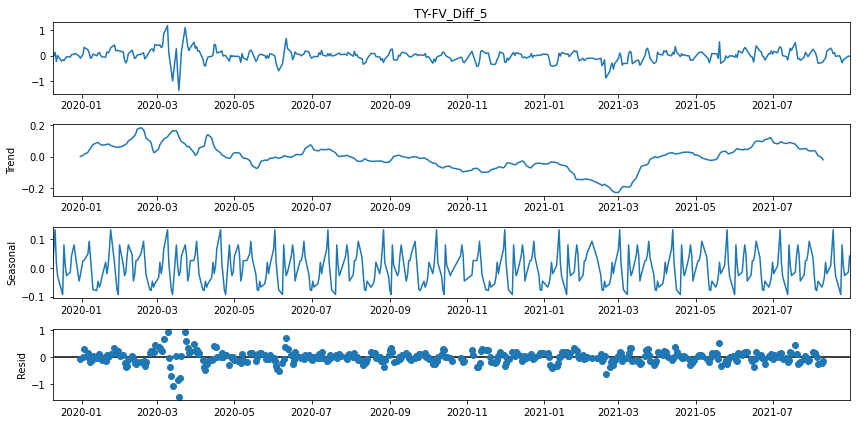

In [28]:
# Spread_TY-FV
seasonality_decomposition5 = sm.tsa.seasonal_decompose((pd.to_numeric(data_tyfv['TY-FV_Diff_5']).dropna()), model='additive', freq=30)
                                                        
plt.rcParams['figure.figsize'] = [12,6]
plt.rcParams.update({'font.size': 10})
seasonality_decomposition5.plot()
None                          

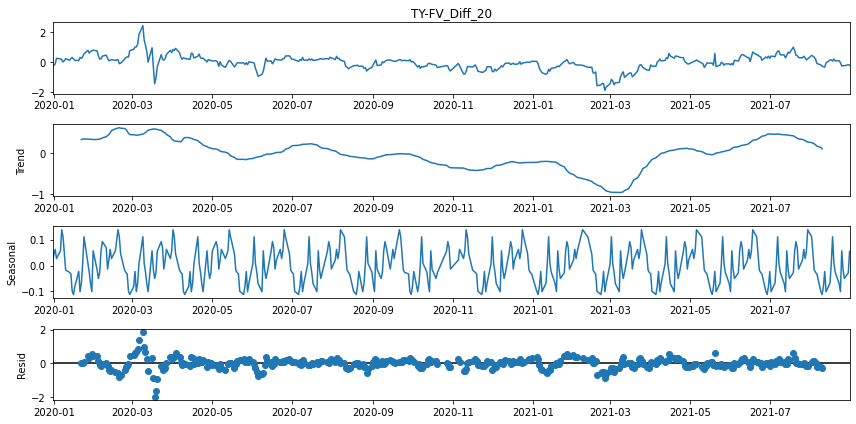

In [29]:
# Spread_TY-FV
seasonality_decomposition20 = sm.tsa.seasonal_decompose((pd.to_numeric(data_tyfv['TY-FV_Diff_20']).dropna()), model='additive', freq=30)
                                                        
plt.rcParams['figure.figsize'] = [12,6]
plt.rcParams.update({'font.size': 10})
seasonality_decomposition20.plot()
None    

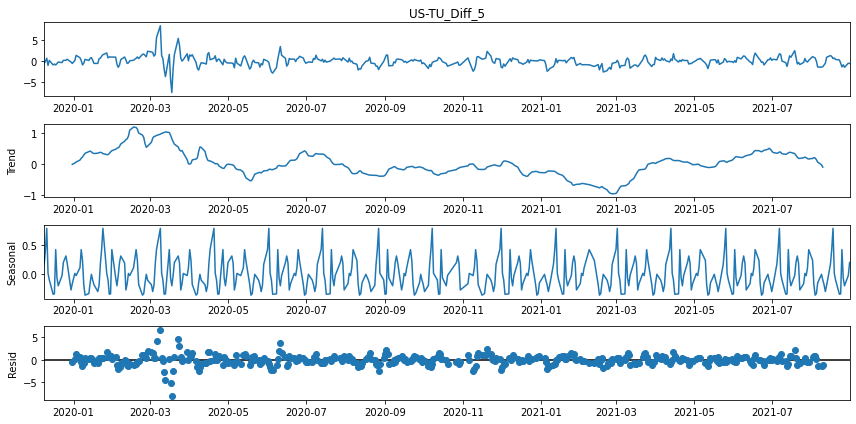

In [30]:
# Spread_US-TU
seasonality_decomposition5 = sm.tsa.seasonal_decompose((pd.to_numeric(data_ustu['US-TU_Diff_5']).dropna()), model='additive', freq=30)
                                                        
plt.rcParams['figure.figsize'] = [12,6]
plt.rcParams.update({'font.size': 10})
seasonality_decomposition5.plot()
None             

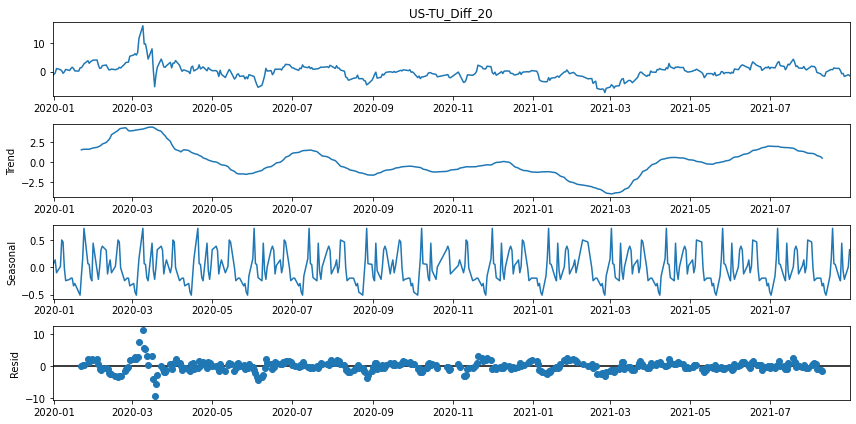

In [31]:
# Spread_US-TU
seasonality_decomposition20 = sm.tsa.seasonal_decompose((pd.to_numeric(data_ustu['US-TU_Diff_20']).dropna()), model='additive', freq=30)
                                                        
plt.rcParams['figure.figsize'] = [12,6]
plt.rcParams.update({'font.size': 10})
seasonality_decomposition20.plot()
None 